## Forward Step LSTM Model

This model attempts to take the trainng data and segment a moving set of 60 readings to predict the i+60th reading for i in a defined range. 

A special data structure is needed to cover 60-time stamps, based on which LSTM will predict the 61st price.  Thus, X_train is a nested list, which contains lists of 60 time-stamp prices. y_train is a list of stock prices which is the next period price, corresponding to each list in X_train. 

In the first run, we use LSTM with 3 layers (12, 12, 24 units) and a learning rate of 1e-05. The time taken to run is considerably long as X_train is a list of 60 time stamps. So I decided to start with minimal layers first. 

In [1]:
import importlib
import datetime as dt
import numpy as np
import pandas as pd
from fxcmpy import fxcmpy_tick_data_reader as tdr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import talib as ta
from talib import RSI, BBANDS
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam

In [3]:
gbp = pd.read_csv(f'C:/Users/STELLA/Desktop/Data Science/DS106/GBPUSD_1min.csv')

In [4]:
del gbp['DateTime']
gbp['Open'] = (gbp['BidOpen'] + gbp['AskOpen'])/2
gbp['Close'] = (gbp['BidClose'] + gbp['AskClose'])/2
gbp['High'] = (gbp['BidHigh'] + gbp['AskHigh'])/2
gbp['Low'] = (gbp['BidLow'] + gbp['AskLow'])/2


In [5]:
gbp = gbp.drop({'Unnamed: 0','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose'}, axis=1)

In [6]:
gbp

,Open,Close,High,Low
0,1.308620,1.308640,1.308875,1.308275
1,1.308640,1.308600,1.308640,1.308600
2,1.308600,1.308050,1.308600,1.308050
3,1.308050,1.307910,1.308055,1.307900
4,1.307910,1.307920,1.308060,1.307845
...,...,...,...,...
355601,1.353405,1.353475,1.353575,1.353385
355602,1.353475,1.353470,1.353520,1.353415
355603,1.353470,1.353475,1.353540,1.353420
355604,1.353475,1.353400,1.353490,1.353370


In [7]:
# create X_train of a moving 60 timestamps and y_train

train_set = gbp.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, len(train_set)-1):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Fitting the LSTM Model

In [8]:
regressor = Sequential()

regressor.add(LSTM(units = 12, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 12, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 24, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [9]:
regressor.compile(optimizer = Adam(lr=1e-05), loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
11111/11111 [==============================] - 528s 47ms/step - loss: 0.0618
Epoch 2/20
11111/11111 [==============================] - 682s 61ms/step - loss: 0.0092
Epoch 3/20
11111/11111 [==============================] - 782s 70ms/step - loss: 0.0044
Epoch 4/20
11111/11111 [==============================] - 675s 61ms/step - loss: 0.0028
Epoch 5/20
11111/11111 [==============================] - 703s 63ms/step - loss: 0.0020
Epoch 6/20
11111/11111 [==============================] - 728s 65ms/step - loss: 0.0015
Epoch 7/20
11111/11111 [==============================] - 843s 76ms/step - loss: 0.0011
Epoch 8/20
11111/11111 [==============================] - 907s 82ms/step - loss: 9.2589e-04
Epoch 9/20
11111/11111 [==============================] - 909s 82ms/step - loss: 8.0191e-04
Epoch 10/20
11111/11111 [==============================] - 998s 90ms/step - loss: 7.2261e-04
Epoch 11/20
11111/11111 [==============================] - 953s 86ms/step - loss: 6.7019e-04
Epoch 12/20
11

### Testing the model on new data

In [19]:
url = 'https://candledata.fxcorporate.com/'##This is the base url
periodicity='m1' ##periodicity, can be m1, H1, D1
url_suffix = '.csv.gz' ##Extension of the file name
symbol = 'GBPUSD' ##symbol we want to get tick data for
##Available Currencies 
##AUDCAD,AUDCHF,AUDJPY, AUDNZD,CADCHF,EURAUD,EURCHF,EURGBP
##EURJPY,EURUSD,GBPCHF,GBPJPY,GBPNZD,GBPUSD,GBPCHF,GBPJPY
##GBPNZD,NZDCAD,NZDCHF.NZDJPY,NZDUSD,USDCAD,USDCHF,USDJPY


##The candle files are stored in compressed csv.  The storage structure comes as {periodicity}/{symbol}/{year}/{week_of_year}.csv.gz
##The first week of the year will be 1.csv.gz where the 
##last week might be 52 or 53.  That will depend on the year.
##Once we have the week of the year we will be able to pull the correct file with the data that is needed.
start_dt =  dt.date(2021,1,15)##random start date
end_dt = dt.date(2021,2,15)##random end date


start_wk = start_dt.isocalendar()[1]##find the week of the year for the start  
end_wk = end_dt.isocalendar()[1] ##find the week of the year for the end 
year = str(start_dt.isocalendar()[0]) ##pull out the year of the start

###The URL is a combination of the currency, periodicity,  year, and week of the year.
###Example URL https://candledata.fxcorporate.com/m1/EURUSD/2017/29.csv.gz
###The example URL should be the first URL of this example
data=pd.DataFrame()
##This will loop through the weeks needed, create the correct URL and print out the lenght of the file.
for i in range(start_wk, end_wk ):
    url_data = url + periodicity + '/' + symbol + '/' + year + '/' + str(i) + url_suffix
    print(url_data)
    tempdata = pd.read_csv(url_data, compression='gzip')
    data =pd.concat([data, tempdata])

print(data)


https://candledata.fxcorporate.com/m1/GBPUSD/2021/2.csv.gz
https://candledata.fxcorporate.com/m1/GBPUSD/2021/3.csv.gz
https://candledata.fxcorporate.com/m1/GBPUSD/2021/4.csv.gz
https://candledata.fxcorporate.com/m1/GBPUSD/2021/5.csv.gz
https://candledata.fxcorporate.com/m1/GBPUSD/2021/6.csv.gz
                     DateTime  BidOpen  BidHigh   BidLow  BidClose  AskOpen  \
0     01/10/2021 22:18:00.000  1.35549  1.35633  1.35549   1.35612  1.35725   
1     01/10/2021 22:19:00.000  1.35612  1.35636  1.35612   1.35636  1.35797   
2     01/10/2021 22:20:00.000  1.35636  1.35637  1.35634   1.35637  1.35797   
3     01/10/2021 22:21:00.000  1.35637  1.35667  1.35605   1.35667  1.35797   
4     01/10/2021 22:22:00.000  1.35667  1.35667  1.35642   1.35667  1.35773   
...                       ...      ...      ...      ...       ...      ...   
7181  02/12/2021 21:55:00.000  1.38528  1.38532  1.38509   1.38523  1.38538   
7182  02/12/2021 21:56:00.000  1.38523  1.38532  1.38504   1.38510  1.385

In [20]:
gbp_test = data
gbp_test.to_csv(f'C:/Users/STELLA/Desktop/Data Science/DS106/GBPUSD_test.csv')

In [21]:
del gbp_test['DateTime']
gbp_test['Open'] = (gbp_test['BidOpen'] + gbp_test['AskOpen'])/2
gbp_test['Close'] = (gbp_test['BidClose'] + gbp_test['AskClose'])/2
gbp_test['High'] = (gbp_test['BidHigh'] + gbp_test['AskHigh'])/2
gbp_test['Low'] = (gbp_test['BidLow'] + gbp_test['AskLow'])/2

In [84]:
gbp_testdata = gbp_test.iloc[:, 1:2].values
dataset_total = pd.concat((gbp['Open'], gbp_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(gbp_test) - 60:].values


In [85]:
inputs

array([1.353815, 1.35376 , 1.353775, ..., 1.385215, 1.38531 , 1.385435])

In [86]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(gbp_testdata)-1):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [87]:
predicted_price= regressor.predict(X_test)


In [88]:
x = predicted_price.reshape(predicted_price.shape[0], 60)
x.shape

(35764, 60)

In [89]:

b = sc.inverse_transform(x)
b

array([[1.3481477, 1.3502307, 1.3506875, ..., 1.3519849, 1.3519884,
        1.3519303],
       [1.3480982, 1.3502446, 1.3507067, ..., 1.3519875, 1.3519293,
        1.3542703],
       [1.3481117, 1.3502628, 1.3506821, ..., 1.3519282, 1.3542694,
        1.3551383],
       ...,
       [1.375106 , 1.3775352, 1.3787373, ..., 1.3827307, 1.3827447,
        1.3827364],
       [1.3751142, 1.3776908, 1.3785458, ..., 1.3827415, 1.3827335,
        1.3827418],
       [1.3752542, 1.3774701, 1.3785102, ..., 1.3827299, 1.3827385,
        1.382677 ]], dtype=float32)

In [90]:
gbp_testdata.shape

(35825, 1)

### Plotting the Predictions vs Real Values

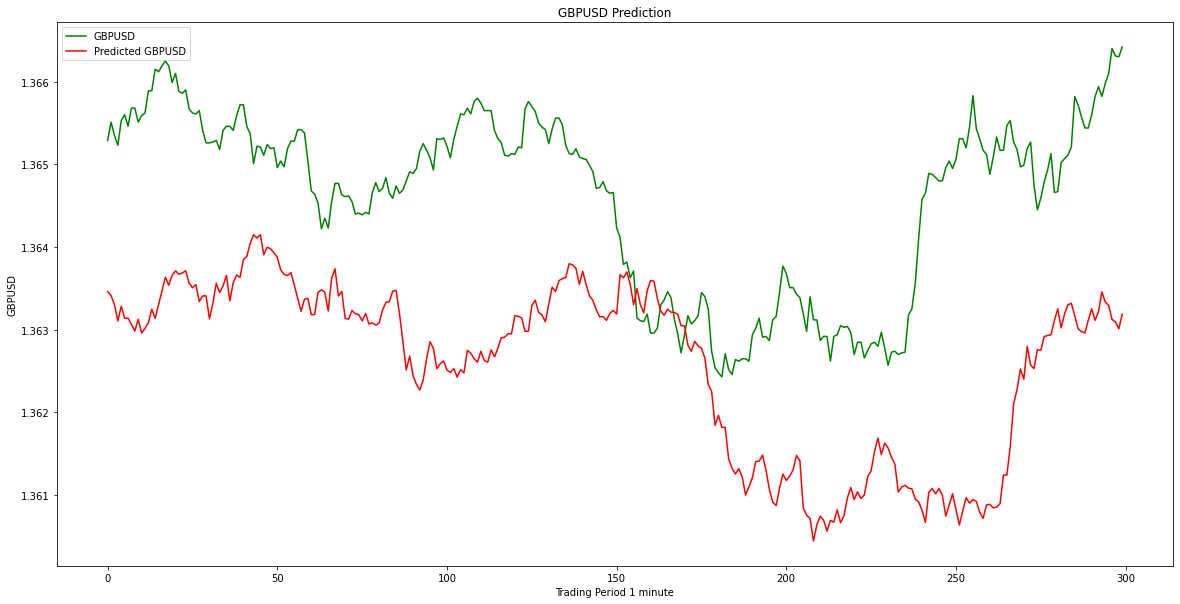

In [91]:
plt.figure(figsize=(20,10))
plt.plot(gbp_testdata[5000:5300], color = 'green', label = 'GBPUSD')
plt.plot(b[5000:5300, 33:34], color = 'red', label = 'Predicted GBPUSD')
plt.title('GBPUSD Prediction')
plt.xlabel('Trading Period 1 minute')
plt.ylabel('GBPUSD')
plt.legend()
plt.show()

### MOST DECENT RESULTS I HAD ALL WEEK!!

Looks like using a number of values of X to predict y is the best approach so far - perhaps a reflection of the law of large numbers coming into play here.

In [94]:
#Saving model -  serialize model to JSON
model_json = regressor.to_json()
with open("gbp_fwdsteplstm_24layer.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
regressor.save_weights("gbp_fwdsteplstm_24layer.h5")
print("Saved model to disk")

Saved model to disk
